# Project Proposal: Exploring Pulsar Star Data

<b>1. Introduction<b>
    
Pulsar stars are a type of Neutron star that produces radio emission detectable on Earth. They are significant as they are used as probes of space-time, the interstellar medium, and states of matter (1).
    
This HTRU2 dataset, taken from (cite kaggle) will inform this project. It shows classifications of stars as either pulsar or non-pulsar stars (1). Light emitted by a pulsar contains information about the physics of neutron stars, which are the densest material in the universe. The precise blink or pulse of a pulsar star can indicate a possible event happening in space, as well. Cosmic distances can be calculated due to the regular periodicity of pulsar stars' light emission and they have been used to test parts of the theory of relativity (2).
 
    
    

<b>a. About the Dataset<b>
    
This dataset uses the mean, standard deviation, excess kurtosis, and skewness of the stars’ integrated profiles and DM-SNR curves to classify whether or not a star can be identified as a pulsar. DM-SNR curves measure the radio waves released by pulsar stars once they reach Earth and have already traveled long distances in space surrounded by free electrons. Used to identify the pulsar as each profile is unique;however, pulse profiles vary slightly each period due to their signals being  non uniform and unstable. Averaged over many  thousands of rotations makes the profiles stable.Means that the distribution of event outcomes have many outliers leading to fat tails on the bell shaped distribution curve. The observations under the Class variable are binary, indicating that a star is a pulsar or non-pulsar. It is for this reason that the Class variable has been converted to a factor, as the observations are discrete. The rest of the variables are continuous values (1).

In [10]:
#1. Download libraries

library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



In [8]:
#2.Read in data Pulsar Star Data

pulsar_star_data<-read_csv("https://raw.githubusercontent.com/madisongill/dsci-100-2023s-group-39-section-002/main/HTRU_2.csv",col_names=FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
#3. Tidy data (add column names,condense if needed,

pulsar <- pulsar_star_data|>
rename(mean=X1,
       std_dev=X2,
       kurt=X3,
       skew=X4,
       mean_dmsnr=X5,
       std_dev_dmsnr=X6,
       kurt_dmsnr=X7,
       skew_dmsnr=X8,
       class=X9) |>
mutate(class = as_factor(class))
       
       
pulsar

mean,std_dev,kurt,skew,mean_dmsnr,std_dev_dmsnr,kurt_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


In [32]:
#4.Split data into training and test set

pulsar_split<-initial_split(pulsar,prop=0.75,strata=class)
pulsar_train<-training(pulsar_split)
pulsar_test<-testing(pulsar_split)

glimpse(pulsar_train)

Rows: 13,423
Columns: 9
$ mean          <dbl> 140.56250, 136.75000, 88.72656, 93.57031, 119.48438, 107…
$ std_dev       <dbl> 55.68378, 57.17845, 40.67223, 46.69811, 48.76506, 52.627…
$ kurt          <dbl> -0.234571412, -0.068414638, 0.600866079, 0.531904850, 0.…
$ skew          <dbl> -0.69964840, -0.63623837, 1.12349169, 0.41672112, -0.112…
$ mean_dmsnr    <dbl> 3.1998328, 3.6429766, 1.1789298, 1.6362876, 0.9991639, 2…
$ std_dev_dmsnr <dbl> 19.110426, 20.959280, 11.468720, 14.545074, 9.279612, 14…
$ kurt_dmsnr    <dbl> 7.975532, 6.896499, 14.269573, 10.621748, 19.206230, 9.0…
$ skew_dmsnr    <dbl> 74.24222, 53.59366, 252.56731, 131.39400, 479.75657, 107…
$ class         <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


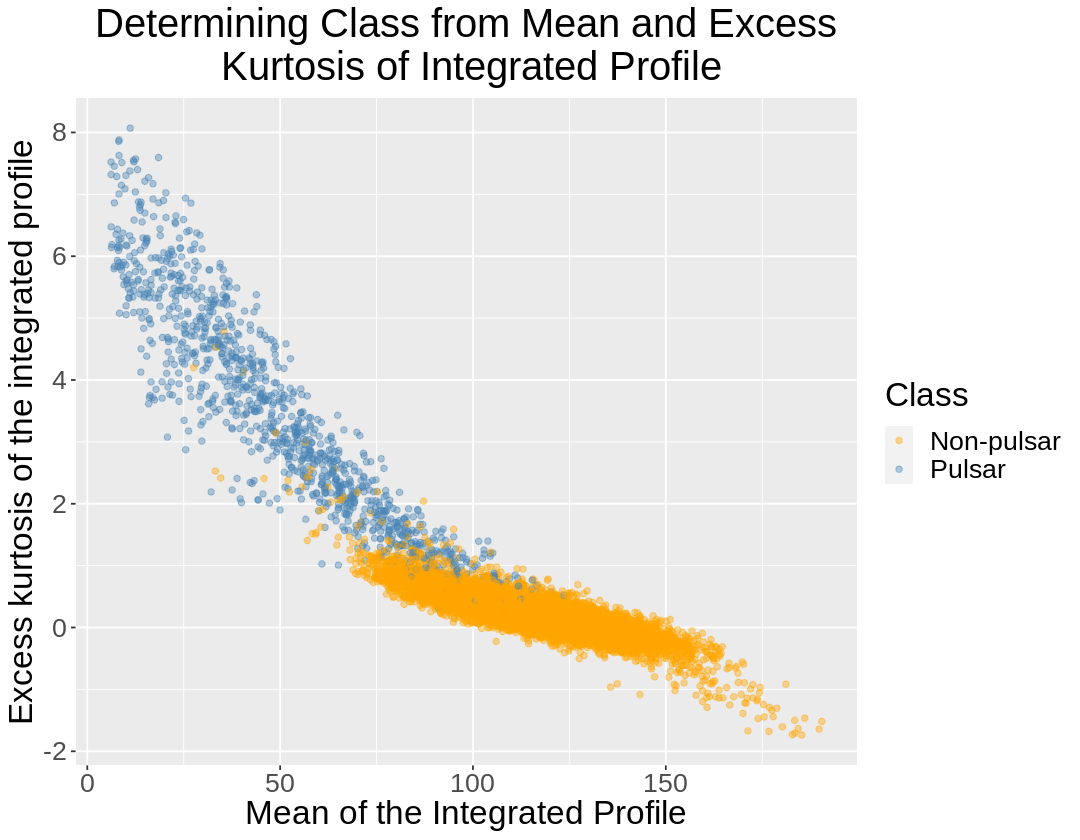

In [33]:
options(repr.plot.width = 9, repr.plot.height = 7)
pulsar_star_graph <- pulsar_train |>
ggplot(aes(x = mean, y = kurt, color = class)) +
geom_point(alpha = 0.4) +
labs(x = "Mean of the Integrated Profile", y = "Excess kurtosis of the integrated profile", color = "Class") +
scale_color_manual(labels = c("Non-pulsar", "Pulsar"),
                   values = c("orange", "steel blue")) +
ggtitle("Determining Class from Mean and Excess\n Kurtosis of Integrated Profile")+
theme(plot.title = element_text(hjust = 0.5))+
theme(text = element_text(size = 20))
pulsar_star_graph

<b>2. Exploratory Data Analysis<b>



    
